# Session 7. 지도학습2
## Decision Tree / Support Vector Machine / Random Foreset / XGBoost

#### 작성자: 5기 공채린
#### 퀘스트 기한: 2019. 10. 13 (일) 23:59

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
df = pd.read_csv('AB_NYC_2019.csv', encoding='utf-8')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


뉴욕의 에어비엔비 데이터셋을 활용하여 방 타입, 숙박 가격, 최소숙박일수, 최근리뷰, 월 리뷰갯수 등으로부터 숙소의 위치를 알아내는 모델

편의상 맨하튼, 브루클린의 숙소들로 범위를 좁혔습니다

In [3]:
our_set = df[df['neighbourhood_group'].isin(['Brooklyn', 'Manhattan'])]
our_set.shape, df.shape

((41765, 16), (48895, 16))

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

### 전체적인 가격대 분포 살펴보기

Text(0, 0.5, 'Ratio')

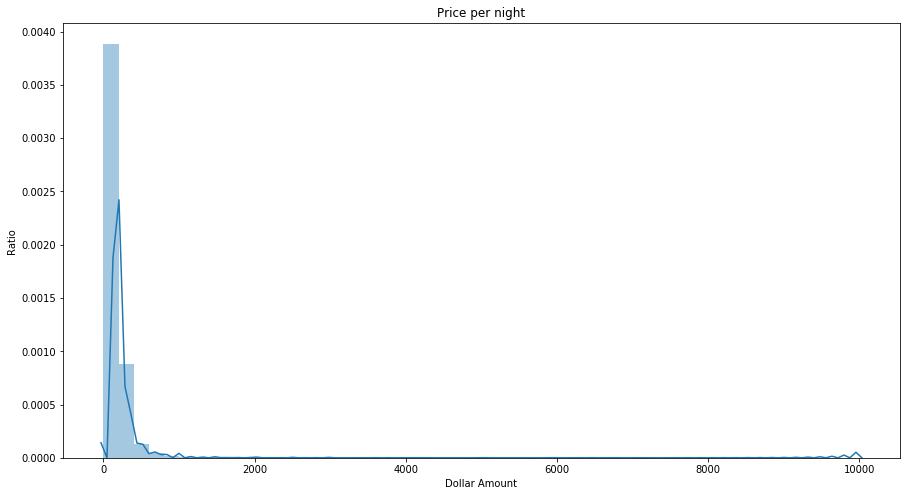

In [5]:
plt.figure(figsize=(15,8))
sns.distplot(our_set['price'])
plt.title("Price per night")
plt.xlabel('Dollar Amount')
plt.ylabel('Ratio')

Text(0, 0.5, 'Ratio')

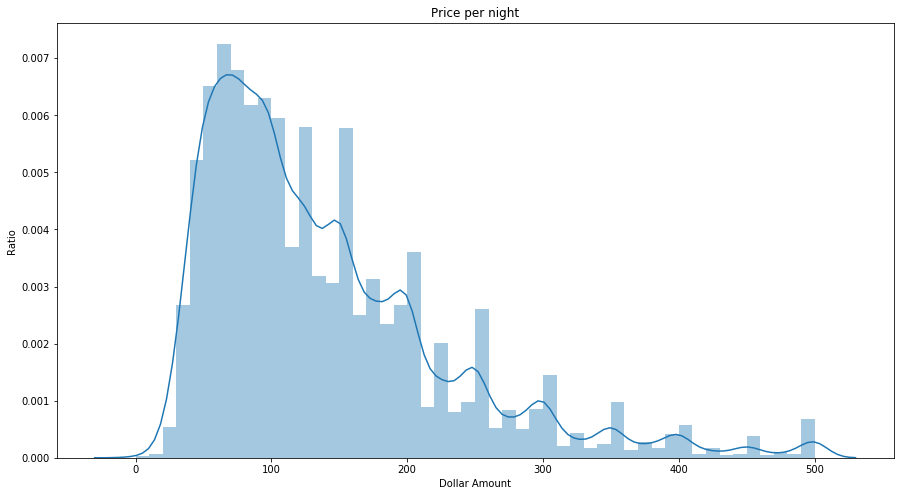

In [6]:
plt.figure(figsize=(15,8))
sns.distplot(our_set[our_set['price']<=500]['price'])
plt.title("Price per night")
plt.xlabel('Dollar Amount')
plt.ylabel('Ratio')

### 방 타입에는 어떤 것들이 있나...

In [7]:
set(our_set['room_type'])

{'Entire home/apt', 'Private room', 'Shared room'}

In [8]:
import random

random_seed = random.randint(0,1000)

### 자연어를 기계가 알아들을 수 있게 수치로 변환

In [9]:
our_set = our_set.replace('Brooklyn', 0).replace('Manhattan', 1)

### 룸 타입 역시 자연어로 되어있으므로, "원핫인코딩"을 통해 수치로 변환

In [10]:
x = pd.get_dummies(our_set['room_type'])
core_cols = our_set[['neighbourhood_group', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']]
combined = core_cols.merge(x, left_index=True, right_index=True, how='left').reset_index()
combined.head()

,index,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,0,149,1,9,0.21,0,1,0
1,1,1,225,1,45,0.38,1,0,0
2,2,1,150,3,0,NaN,0,1,0
3,3,0,89,1,270,4.64,1,0,0
4,4,1,80,10,9,0.10,1,0,0


### 불필요한 컬럼 제거, 결측치 제외

In [11]:
final = combined.drop(columns=['index']).dropna()
final.shape

(33079, 8)

In [15]:
conda install -c conda-forge missingno

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\User\Anaconda3

  added / updated specs:
    - missingno


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.9.11  |       hecc5488_0         181 KB  conda-forge
    certifi-2019.6.16          |           py37_1         149 KB  conda-forge
    conda-4.7.12               |           py37_0         3.0 MB  conda-forge
    missingno-0.4.2            |             py_0          12 KB  conda-forge
    openssl-1.1.1c             |       hfa6e2cd_0         4.7 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         8.1 MB

The following NEW packages will be INSTALLED:

  missingno          conda-forge/noarch::missingno-0.4.2-py_0

The following packages will be UPDATED:

  ca-certificates    pkgs/main:

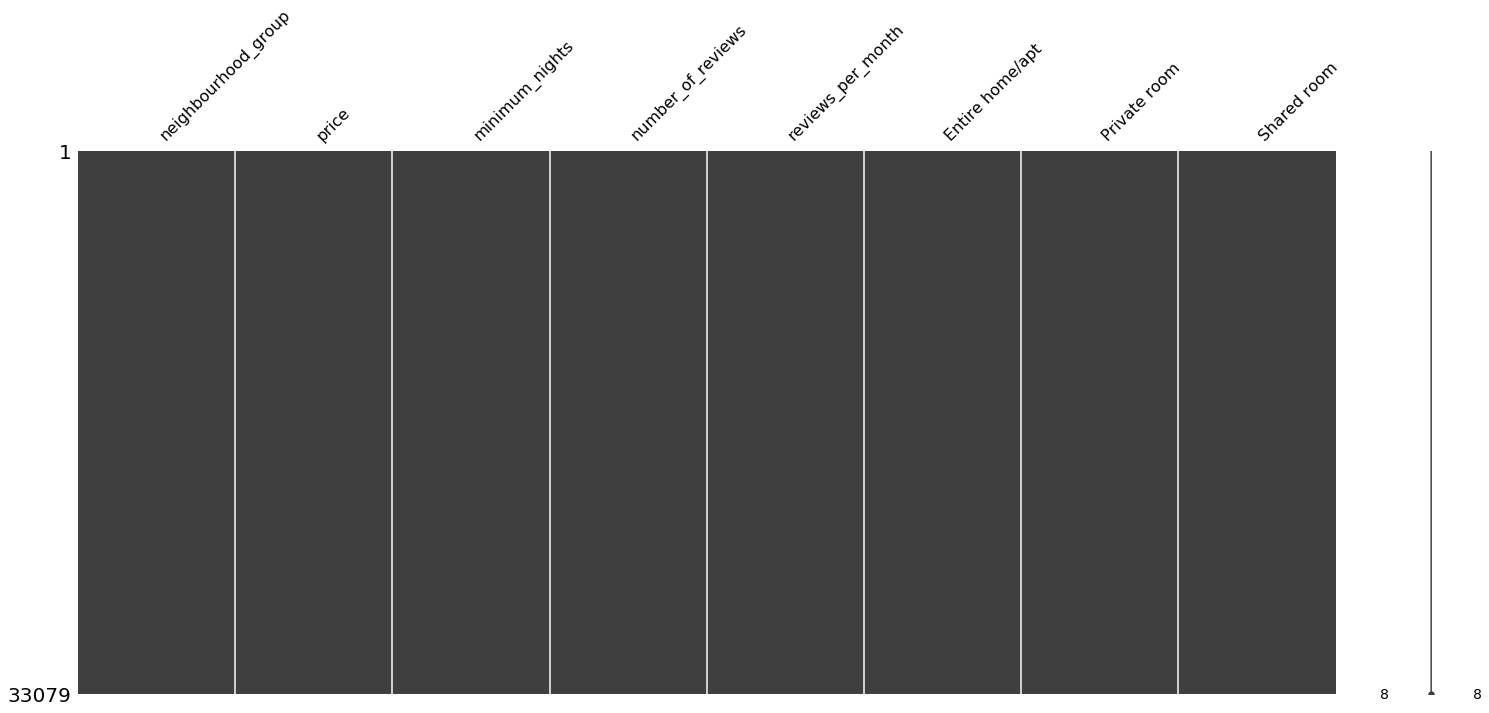

In [16]:
### 혹시 아직 결측치가 남아있는지 최종 점검

import missingno as msno
msno.matrix(final)

In [17]:
final.head()

,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,149,1,9,0.21,0,1,0
1,1,225,1,45,0.38,1,0,0
3,0,89,1,270,4.64,1,0,0
4,1,80,10,9,0.10,1,0,0
5,1,200,3,74,0.59,1,0,0


In [18]:
bk = len(final[final['neighbourhood_group']==0])
mh = len(final[final['neighbourhood_group']==1])
tt = len(final)
print("브루클린 건은 {0}건({2:.1f}%), 맨하탄 건은 {1}건({3:.1f}%)이네요.".format(bk, mh, 100*bk/tt, 100*mh/tt))

브루클린 건은 16447건(49.7%), 맨하탄 건은 16632건(50.3%)이네요.


### 본격적인 모델링 - 랜덤포레스트

In [19]:
### 랜덤 시드를 활용하여 트레인, 테스트셋 분리 / 3:1 비율로

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']], final['neighbourhood_group'], 
                                                    test_size=0.25, random_state=random_seed)

In [20]:
### 랜덤포레스트 모델 수립, 대충 하이퍼 파라미터 제공
import time
from sklearn.ensemble import RandomForestClassifier
random_seed = random.randint(0,1000)
rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=random_seed)
### 학습 진행
t0 = time.time()
rf.fit(X_train, y_train)
elapsed = time.time()-t0
print("걸린시간은 {:.2f}초입니다.".format(elapsed))

걸린시간은 6.75초입니다.


In [21]:
from sklearn.metrics import accuracy_score

### 학습된 모델로 분류 예측
prediction = rf.predict(X_test)
### 채점
accuracy = accuracy_score(y_test, prediction)
### 성적 발표
print(f'Mean accuracy score: {100*accuracy:.3}%')

Mean accuracy score: 60.4%


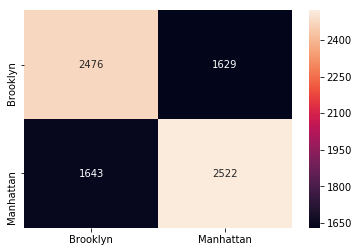

In [22]:
### 오답/정답 시각화를 위한 간단한 히트맵
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, prediction), columns=['Brooklyn', 'Manhattan'], index=['Brooklyn', 'Manhattan'])
sns.heatmap(cm, annot=True, fmt='d')

### 모델링 참고사항 - XGBOOST

In [23]:
!pip install xgboost 
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [24]:
prediction2 = clf.predict(X_test)
accuracy2 = accuracy_score(y_test, prediction2)
print('정확도 : {:.3f}%'.format(100*accuracy2))

정확도 : 64.607%


# ★퀘스트★

### 오늘 배운 모델들을 활용하여 (DT, SVM, XGBOOST / RF는 제외!!) 이보다 더 정교한 모델을 만들어보아요.
### 목표는 정확도 > 60%

(+추가)
같은 모델이더라도, 하이퍼 파라미터를 바꿔가며 코드를 실행해보면 결과가 달라집니다. 

time 모듈을 활용하여 각 모델별로 걸리는 시간도 측정해보아요.

생각보다 높은 정확도를 기록하였다면, 캐글에도 한번 등록해보아요. (https://kaggle.com)

모르는 게 있으면 질문도 좋습니다.

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
from sklearn import tree

In [33]:
import pandas as pd
import numpy as np    
import os

In [34]:
!pip install pydotplus 

  Stored in directory: C:\Users\User\AppData\Local\pip\Cache\wheels\35\7b\ab\66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [35]:
import pydotplus 

In [36]:
from IPython.display import Image

In [39]:
final.head()

,neighbourhood_group,price,minimum_nights,number_of_reviews,reviews_per_month,Entire home/apt,Private room,Shared room
0,0,149,1,9,0.21,0,1,0
1,1,225,1,45,0.38,1,0,0
3,0,89,1,270,4.64,1,0,0
4,1,80,10,9,0.10,1,0,0
5,1,200,3,74,0.59,1,0,0


In [40]:
X = np.array(pd.DataFrame(final, columns=['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']))

In [41]:
y = np.array(pd.DataFrame(final, columns=['neighbourhood_group']))

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=7777)

In [143]:
dt_clf = DecisionTreeClassifier()

In [144]:
dt_clf = dt_clf.fit(X_train, y_train)

In [145]:
dt_prediction = dt_clf.predict(X_test)

In [146]:
realfinal = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
realfinal.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [147]:
from sklearn.metrics import accuracy_score

y_pred_tr = realfinal.predict(X_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_tr))

Accuracy: 0.63
